In [1]:
import itertools, copy
import json
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../peptidome.mplstyle')

import evcouplings.align, evcouplings.couplings

import sys
sys.path.append('..')
from lib import *
from lib import maxent

In [224]:
k = 3
q = len(aminoacids)

In [3]:
humanseqs = [s for s in fasta_iter(human, returnheader=False)]

In [4]:
train, test = train_test_split(humanseqs, test_size=0.5)

In [5]:
empirical_kmers = [string[i:i+k] for string in train for i in range(len(string)-k+1) if isvalidaa(string[i:i+k])]

In [6]:
seqmat = np.array([list(kmer) for kmer in empirical_kmers])

In [7]:
map_ = map_ = {c: i for i, c in enumerate(aminoacids)}
mapped_seqmat = evcouplings.align.map_matrix(seqmat, map_)

In [8]:
fi = evcouplings.align.frequencies(mapped_seqmat, np.ones(len(seqmat)), num_symbols=len(aminoacids))

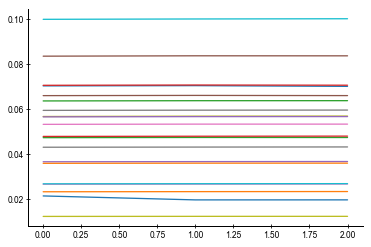

In [9]:
plt.plot(fi);

In [10]:
fij = evcouplings.align.pair_frequencies(mapped_seqmat, np.ones(len(seqmat)), num_symbols=len(aminoacids), fi=fi)

In [11]:
cij = evcouplings.couplings.compute_covariance_matrix(fi, fij)

In [38]:
cij.shape

(57, 57)

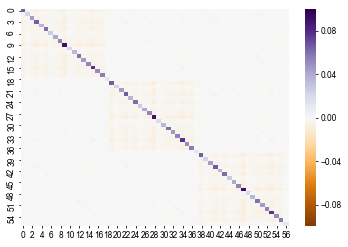

In [27]:
sns.heatmap(cij, vmin=-0.1, vmax=0.1, cmap='PuOr')

In [28]:
q = len(aminoacids)
N = k
cij.shape, N*(q-1)

((57, 57), 57)

In [144]:
C = cij.copy()
D = np.diag(np.diagonal(cij))
A = C.copy()
A[np.diag_indices_from(A)] = 0.0

In [152]:
np.diagonal(cij).min(), A.max()

(0.012013807341812188, 0.003004430103621925)

In [191]:
invC = np.linalg.inv(D)

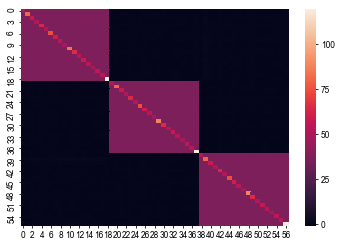

In [215]:
sns.heatmap(invC)

In [216]:
Dinv = np.diag(1/np.diagonal(cij))
A = cij.copy()
A[np.diag_indices_from(A)] = 0.0
invCapprox = Dinv-Dinv@A@Dinv

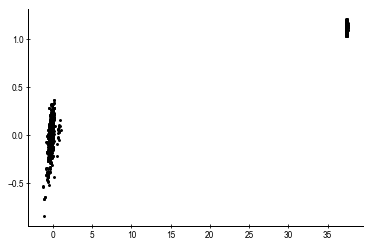

In [217]:
mask = ~np.eye(invC.shape[0],dtype=bool)
plt.plot(invC[mask].flatten(), invCapprox[mask].flatten(), 'k.')

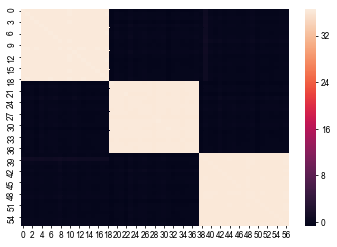

In [221]:
sns.heatmap(invC-invCapprox)

In [310]:
def JijfrominvC(invC):
    Jij = evcouplings.couplings.reshape_invC_to_4d(invC, seqmat.shape[1], len(aminoacids))
    Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)
    return Jij_zerogauge

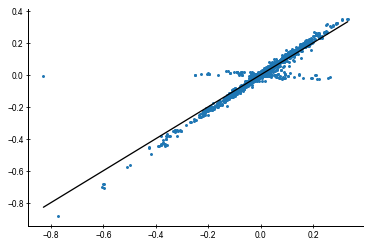

In [311]:
Jij_zerogauge = JijfrominvC(invC)
Jij_zerogauge_approx = JijfrominvC(invCapprox)
plt.plot(Jij_zerogauge.flatten(), Jij_zerogauge_approx.flatten(), '.')
x = np.linspace(min(Jij_zerogauge.flatten()), max(Jij_zerogauge.flatten()))
plt.plot(x, x, 'k')

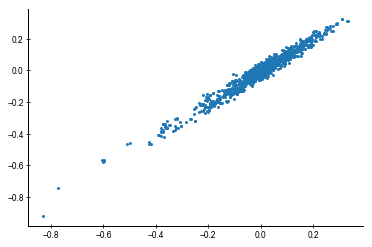

In [312]:
rhoij = np.zeros(fij.shape)
for i in range(k):
    for j in range(k):
        rhoij[i, j] = fij[i, j]/np.outer(fi[i], fi[j]) - 1.0
#mask = np.abs(Jij_zerogauge) > 1e-5
plt.plot(Jij_zerogauge[mask].flatten(), -rhoij[mask].flatten(), '.')

In [317]:
Jij = -rhoij
Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)

In [316]:
Jij_zerogauge = Jij_zerogauge_approx

In [318]:
hi = evcouplings.couplings.fields(Jij_zerogauge, fi)
print(hi)

#for i in range(hi.shape[0]):
#    for a in range(hi.shape[1]):
#        hi[i, a] += np.sum(Jij[i, :, a, :])

[[ 0.9114505  -0.12630551  0.57785088  0.94437434  0.34834357  0.88030791
   0.01886954  0.51884712  0.77211002  1.29508689 -0.23319699  0.32585433
   0.79733963  0.56883558  0.74788911  1.10205372  0.672162    0.79875919
  -0.74515238  0.07511838]
 [ 0.905245   -0.11910528  0.56771084  0.93287582  0.34486909  0.88361736
   0.02378323  0.52433223  0.75712599  1.30343516 -0.29810333  0.32718346
   0.79182029  0.56498432  0.74012148  1.11404964  0.68985999  0.79667529
  -0.7423608   0.05563449]
 [ 0.89849686 -0.0907017   0.56917386  0.92948082  0.33983095  0.87429896
   0.0199145   0.50369019  0.765541    1.30375472 -0.29640722  0.33255715
   0.80240635  0.57341906  0.7432942   1.10878788  0.68483378  0.79097913
  -0.75056725  0.03868798]]


In [261]:
N = k
q = 20
cij_flat = cij.reshape(N, q-1, N, q-1)

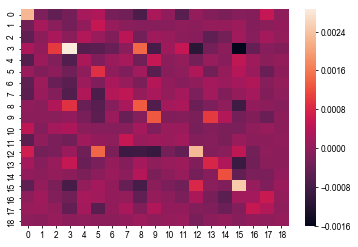

In [262]:
sns.heatmap(cij_flat[0, :, 1, :])

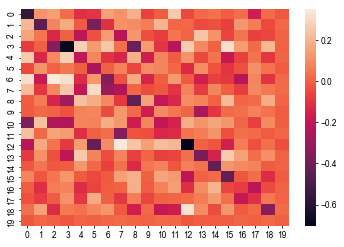

In [93]:
sns.heatmap(Jij_zerogauge_approx[0, 1])

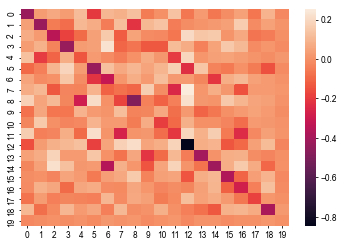

In [70]:
sns.heatmap(Jij_zerogauge[0, 2])

In [229]:
import numba
@numba.jit(nopython=True)
def energy_potts(x, hi, Jij):
    e = 0
    for i in range(len(x)):
        e += hi[i, x[i]]
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            e += Jij[i, j, x[i], x[j]]
    return -e

In [319]:
jump = lambda x: np.random.randint(q, size=k)
x0 = jump(0)
samples = mcmcsampler(x0, lambda x: energy_potts(x, hi, -Jij_zerogauge), jump, 1e6)

In [320]:
fi_model = evcouplings.align.frequencies(samples, np.ones(len(samples)), num_symbols=q)
fij_model = evcouplings.align.pair_frequencies(samples, np.ones(len(samples)), num_symbols=q, fi=fi_model)
cij_model = evcouplings.couplings.compute_covariance_matrix(fi_model, fij_model).flatten()

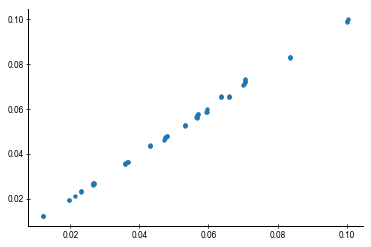

In [321]:
plt.plot(fi.flatten(), fi_model.flatten(), 'o')

(-0.01, 0.01)

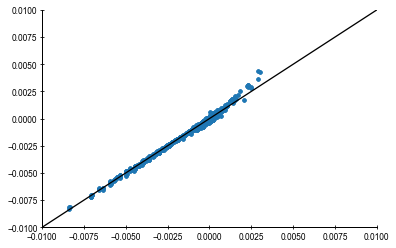

In [322]:
plt.plot(cij.flatten(), cij_model.flatten(), 'o')
x = [-0.01, 0.01]
plt.plot(x, x, 'k')
plt.xlim(-0.01, 0.01)
plt.ylim(-0.01, 0.01)

In [323]:
kmers = [''.join(s) for s in itertools.product(aminoacids, repeat=k)]
df = pd.DataFrame.from_dict(dict(seq=kmers, freq=np.zeros(len(kmers))))
df.set_index('seq', inplace=True)
df['freq'] = df['freq'].add(maxent.count(train, k)['freq'], fill_value=0.0)
df['freq_test'] = np.zeros(len(kmers))
df['freq_test'] = df['freq_test'].add(maxent.count(test, k)['freq'], fill_value=0.0)

In [324]:
df['freq_maxent'] = np.exp([-energy_ising(evcouplings.align.map_matrix(list(s), map_), hi, -Jij_zerogauge) for s in kmers])
df['freq_maxent'] /= np.sum(df['freq_maxent'])
jsd_maxent = calc_jsd(df['freq_test'], df['freq_maxent'], base=2)
jsd_maxent, scipy.stats.entropy(df['freq_maxent'], base=2)

(0.0024495630121220873, 12.477674841942928)

In [325]:
Sind = sum([scipy.stats.entropy(fi[i], base=2) for i in range(fi.shape[0])])
Itot = 0.0
for i in range(fij.shape[0]):
    for j in range(i+1, fij.shape[0]):
        I = np.sum(fij[i, j]*np.log2(fij[i, j]/np.outer(fi[i], fi[j])))
        print(i, j, I)
        Itot += I
Sind, Itot, Sind-Itot

0 1 0.013950119066306658
0 2 0.009978930763845097
1 2 0.013879731080027703


(12.527372248664403, 0.03780878091017946, 12.489563467754223)

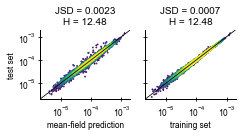

In [285]:
scatter = lambda x, y, ax: plotting.density_scatter(x, y, ax=ax, s=1, bins=100,
                                           trans=lambda x: np.log(x+1e-8),
                                           norm=matplotlib.colors.LogNorm(vmin=0.5, vmax=50 if k ==3 else 400),
                                           cmap='viridis')
#scatter = lambda x, y, ax: ax.scatter(x, y, s=1, alpha=1, edgecolor=None)

fig, axes = plt.subplots(figsize=(3.5, 2.0), ncols=2, sharex=True, sharey=True)
axes[0].set_ylabel('test set')

for ax, column, xlabel in [(axes[0], 'freq_maxent','mean-field prediction'),
                           (axes[1], 'freq', 'training set')
                            ]:
    scatter(df[column], df['freq_test'], ax)
    ax.set_xlabel(xlabel)
    jsd = calc_jsd(df['freq_test'], df[column], base=2)
    entropy = scipy.stats.entropy(df[column], base=2)
    ax.set_title('JSD = {:.4f}\nH = {:.2f}'.format(jsd, entropy))
    
if k == 3:
    x = np.logspace(-5.7, -2.7)
elif k == 4:
    x = np.logspace(-7.7, -2.9)
for ax in axes:
    ax.plot(x, x, 'k', lw=0.8)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(x), max(x))
    ax.set_xscale('log')
    ax.set_yscale('log')
fig.tight_layout()
fig.savefig('main.png' if k == 3 else 'comparison_k4.png', dpi=600)

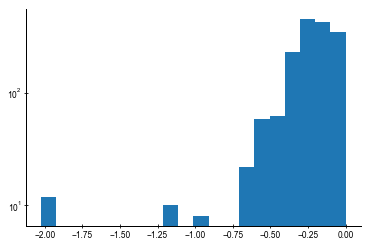

In [223]:
plt.hist(np.diagonal(Jij_zerogauge, axis1=2, axis2=3).flatten(), bins=20)
plt.yscale('log')

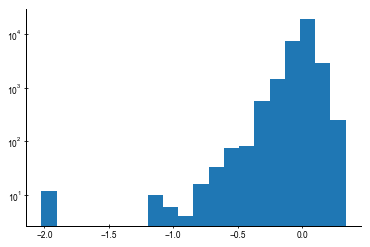

In [185]:
plt.hist(Jij_zerogauge.flatten(), bins=20)
plt.yscale('log')

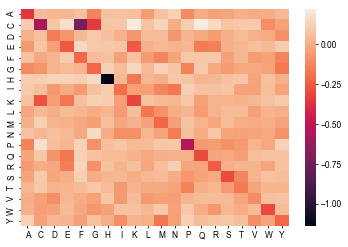

In [220]:
sns.heatmap(pd.DataFrame(Jij_zerogauge[0, 4], index=list(aminoacids), columns=list(aminoacids)))#.reshape(N*q, N*q))

In [33]:
alignment = evcouplings.align.Alignment(seqmat,
                                        sequence_ids=[str(i)+'/1-4' if i == 0 else '' for i in range(len(seqmat))],
                                        alphabet=evcouplings.align.ALPHABET_PROTEIN_NOGAP)

ValueError: Default - is not in alphabet ACDEFGHIKLMNPQRSTVWY

In [101]:
mfdca = evcouplings.couplings.MeanFieldDCA(alignment)

In [102]:
fit = mfdca.fit(pseudo_count=0.5)

In [103]:
fit.J_ij.shape

(4, 4, 21, 21)

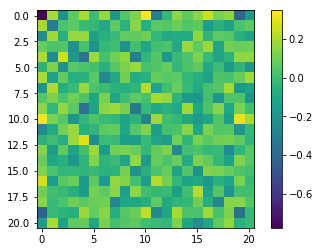

In [110]:
plt.imshow(evcouplings.couplings.model._zero_sum_gauge(fit.J_ij)[0, 1])
plt.colorbar()